# Stochastic Optimal Control

The goal of this notebook is to investigate whether the eigenfunction method can be used to solve stochastic optimal control problems. In particular, we wish to investigate how the eigenfunction approximation performs for increasing $k$ and compare with SOTA.

## Problem Setting

We consider a controlled stochastic process
$$dX_t^u = (b(X_t^u,t) + \sigma(t) u(X_t^u,t)) dt + \sqrt{\lambda} \sigma(t) dW_t$$
where $u$ is the control. The goal is to minimize the cost function
$$\mathbb{E}\left[\int_0^T \left(\frac{1}{2}\|u(X_t,t)\|^2 + f(X_t^u,t)\right)dt + g(X_T^u)\right],$$
where $f$ is some running cost and $g$ is the terminal cost. To do this, introduce the cost functional
$$ J(u;x,t) = \mathbb{E} \left[\int_t^T \left(\frac{1}{2}\|u(X_t,t)\|^2 + f(X_t^u,t)\right)dt + g(X_T^u){\Large|} X_t^u = x\right]$$
which gives the expected cost when using control $u$, starting from position $x$ at time $t$. The <i>value function</i> is then defined through
$$V(x,t) = \inf_{u} J(u;x,t)$$
It can be shown that the optimal control is related to the value function as
$$u^*(x,t) = -\sigma(t)^T \nabla V(x,t).$$

The idea of our method is to use the following path integral representation of the value function:
$$V(x,t) = -\lambda \log \mathbb{E}\left[\exp\left(-\lambda^{-1} \int_{t}^T f(X_s,s) ds - \lambda^{-1} g(X_T)\right) {\Large|} X_t = x\right]$$

By the Feynman-Kac theorem, the above expectation satisfies the PDE
$$\frac{\partial v}{\partial t} - \mathcal{L} v - \lambda^{-1} f(x,t)v = 0, \qquad v(T,x) = \exp\left(-\lambda^{-1}g(x)\right)$$
where $\mathcal{L}$ is the negative of the infinitesimal generator of the diffusion,
$$\mathcal{L} = - \frac{\lambda}{2} (\sigma \otimes \sigma)\nabla^2 - b^T\nabla.$$
In particular, the setting we are interested in is where $b(x,t) = -\nabla E(x)$ for some energy $E$, and $\sigma(t) = \sigma_0 I$. In this case the PDE can be rewritten as
$$\frac{\partial v}{\partial t} + \mathcal{L}v + \lambda^{-1} f(x,t) v = 0, \qquad v(0,x) = \exp\left(-\lambda^{-1}g(x)\right)$$
where $\mathcal{L}$ is the negative infinitesimal generator of Langevin dynamics,
$$\mathcal{L}v = -\frac{\lambda}{2}\sigma_0^2 \Delta v + <\nabla E, \nabla v>.$$
Now the idea is that we can consider the eigenfunctions of the operator $\mathcal{K}$ defined through
$$\mathcal{K}v = \mathcal{L}v + \lambda^{-1} f(x,t) v.$$
This operator is self-adjoint w.r.t to the $L^2$ metric weighted with $\mu(x) = \exp\left(-\frac{2}{\lambda\sigma_0^2}E(x)\right)$. Denoting the eigensystem as $(\phi_i, \lambda_i)$, then we can solve the PDE as
$$v(x,t) = \sum_{k=0}^\infty <e^{-\lambda^{-1}g}, \phi_k>_\mu \phi_k e^{-\lambda_k t}$$
and retrieve the optimal control as 
$$V(x,t) = -\lambda \log v(x,t), \qquad u^*(x,t) = \sigma_0\lambda \frac{\nabla v(x,t)}{v(x,t)}$$
The essential question is now the following: is this solution good if we truncate this solution to only use a limited number of eigenfunctions? This is what we set out to answer in this notebook.




## Imports

In [1]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# Get the parent directory (one level above)
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
import math

from tqdm import tqdm

from src.energy.quadratic import QuadraticEnergy
from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver

## LQR

### Setup

We consider first a setting where we know the eigenfunctions exactly. This is the case for the Linear-Quadratic Regulator, which has
$$E(x) = -\frac{1}{2}x^T A x,\quad b(x) = Ax,\quad f(x,t) = x^T P x,\quad g(x) = x^T Q x.$$
That is: the energy, running and terminal cost are all quadratic. In this case, one can solve the system exactly using the Ricatti equation to obtain the optimal control
$$u_t^*(x) = -2\sigma_0 F_t x$$
where $F_t$ is the solution to the Ricatti equation
$$\frac{dF_t}{dt} + A^T F_t + F_tA - 2F_t \sigma_0^2 F_t + P = 0, \qquad F_T = Q$$

In [2]:
# The following code is copy-pasted from SOC-Matching GitHub
def solution_Ricatti(R_inverse, A, P, Q, t):
    FT = Q
    Ft = [FT]
    for t0, t1 in zip(t[:-1], t[1:]):
        dt = t1 - t0
        FT = FT - dt * (
            -torch.matmul(torch.transpose(A, 0, 1), FT)
            - torch.matmul(FT, A)
            + 2 * torch.matmul(torch.matmul(FT, R_inverse), FT)
            - P
        )
        Ft.append(FT)
    Ft.reverse()
    return torch.stack(Ft)

def optimal_control_LQ(sigma, A, P, Q, t):
    R_inverse = torch.matmul(sigma, torch.transpose(sigma, 0, 1))
    Ft = solution_Ricatti(R_inverse, A, P, Q, t)
    ut = -2 * torch.einsum("ij,bjk->bik", torch.transpose(sigma, 0, 1), Ft)
    return ut

The metric that is used in the SOCM paper is the following:
$$\mathbb{E}_{t, \mathbb{P}^{u^*}} \left[\|u^*(X_t,u^*) - u(X_t^{u^*})\|^2\right]$$
Hence we need to generate some trajectories from the optimal control.

In [3]:
def sde_step(x, dt, u, params):
    """
    Simulate one step of the dynamical system, using the control u
    Args:
        x (tensor)[N,d]: initial points
        dt (float): timestep
        u (tensor)[N,d]: control
        params (dict): problem parameters
    Returns:
        x_new (tensor)[N,d]: new points
    """
    A = params['A']
    sigma = params['sigma']
    lmbda = params['lmbda']

    dw = torch.randn(x.shape)
    x_new = x + (x@A + u @ sigma) * dt + np.sqrt(lmbda * dt) * dw @ sigma
    return x_new

def optimal_control_trajectory(x, T, K, params, seed = 0):
    """
    Simulate the optimal control trajectory starting from x in [0,T] using K discretization steps.
    Args:
        x (tensor)[N,d]: initial points
        T (float): final time
        K (int): timesteps
        params (dict): problem parameters
            A (tensor)[d,d]: drift matrix
            P (tensor)[d,d]: running cost matrix
            Q (tensor)[d,d]: terminal cost matrix
            sigma (tensor)[d,d]: noise matrix
            lmbda (float): noise scale
        seed (int): random seed
    Returns:
        trajectory (tensor)[K+1,N,d]: trajectory under optimal control
    """
    
    A = params['A']
    P = params['P']
    Q = params['Q']
    
    sigma = params['sigma']
    lmbda = params['lmbda']
    
    torch.manual_seed(seed)

    dt = T / (K + 1)
    t = torch.linspace(0,T, 10*K + 1)
    ut = optimal_control_LQ(sigma, A, P, Q, t)[::10]

    trajectory = torch.zeros((K+1,) + x.shape)
    control = torch.zeros((K+1,) + x.shape)
    trajectory[0] = x
    
    u_opt = x @ ut[0] 
    control[0] = u_opt

    for i in tqdm(range(1,K+1)):
        x = sde_step(x, dt, u_opt, params)
        u_opt = x @ ut[i]
        trajectory[i] = x
        control[i] = u_opt
    
    return trajectory, control

def no_control_trajectory(x, T, K, params, seed = 0):
    """
    Simulate the optimal control trajectory starting from x in [0,T] using K discretization steps.
    Args:
        x (tensor)[N,d]: initial points
        T (float): final time
        K (int): timesteps
        params (dict): problem parameters
        seed (int): random seed
    Returns:
        trajectory (tensor)[K+1,N,d]: trajectory under optimal control
    """
    
    torch.manual_seed(seed)
    
    dt = T / (K + 1)
    t = torch.linspace(0,T, 10*K + 1)

    trajectory = torch.zeros((K+1,) + x.shape)
    trajectory[0] = x
    control = torch.zeros_like(x)

    for i in tqdm(range(1,K+1)):
        x = sde_step(x, dt, control, params)
        trajectory[i] = x
    
    return trajectory

### 1D demo

The following illustrates the optimal control for $d = 1$

In [4]:
torch.set_default_device('cpu')
torch.set_default_dtype(torch.float64)

In [5]:
dim = 1
A = torch.eye(dim) * 0.2 
P = torch.eye(dim) * 0.2
Q = torch.eye(dim) * 0.1
sigma = torch.eye(dim)
lmbda = 1.0
T = 5

params = {'A': A, 'P': P, 'Q': Q, 'sigma': sigma, 'lmbda': lmbda, T: 't'}

K = 1000
x = torch.randn((10000,dim)) + 5
t = torch.linspace(0,1,K+1)

trajectory, control = optimal_control_trajectory(x, T, K, params, seed = 0)
free_trajectory = no_control_trajectory(x, T, K, params, seed = 0)

100%|██████████| 1000/1000 [00:00<00:00, 2827.25it/s]


Text(0.5, 1.0, 'Optimal control for quadratic OU problem with positive drift')

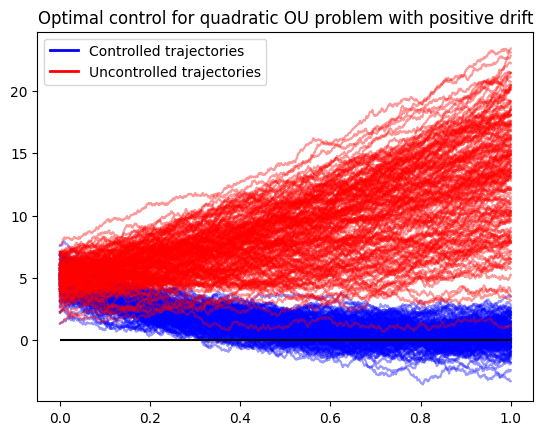

In [6]:
from matplotlib.lines import Line2D

i = 150
plt.plot(t, trajectory[:,:i,0], color = 'blue', alpha = .4)
#plt.plot(t, control[:,i,0], color = 'blue', ls = '--')

#plt.twinx()
plt.plot(t, free_trajectory[:,:i,0], color = 'red', alpha = .4, label = 'uncontrolled')
plt.hlines(0,t[0],t[-1], color = 'black')

custom_lines = [
    Line2D([0], [0], color='b', lw=2, label='Controlled trajectories'),
    Line2D([0], [0], color='r', lw=2, label='Uncontrolled trajectories')
]

plt.legend(handles=custom_lines)
plt.title('Optimal control for quadratic OU problem with positive drift')

### Eigenfunctions

Now, let us construct the eigenfunctions for the operator $\mathcal{K}$. In the LQR case with $\sigma_0 = 1$,
$$\mathcal{K}v = -\frac{\lambda}{2} \Delta v - <Ax, \nabla v> + \lambda^{-1} x^T P x\ v.$$
We can rewrite this as 
$$\mathcal{K}v = \frac{\lambda}{2} \left(-\Delta v -  \frac{2}{\lambda} < Ax, \nabla v> + \frac{2}{\lambda^2} x^T P x v\right)$$
Now suppose that $D^*$ is the matrix such that
\begin{equation}
-(D^*)^T D^* + \frac{2}{\lambda}AD^* +\frac{2}{\lambda^2} P = 0.
\end{equation}
Then it holds that for $v(x) = w(x) \exp\left(-\frac{1}{2}x^T D^* x\right)$,
$$\mathcal{K}v = \frac{\lambda}{2} \left(-\Delta w + <\left(-\frac{2}{\lambda}A + 2D^*\right)x, \nabla w> + \text{Tr}(D^*)w\right)\exp\left(-\frac{1}{2}x^T D^* x\right)$$


We can compute the functions $w_\alpha$ which are eigenfunctions for the term in brackets (with eigenvalue $\tilde\lambda_\alpha$), and then the eigensystem for $\mathcal{K}$ is given by
$$\phi_\alpha(x) = w_\alpha(x) \exp\left(-\frac{1}{2}x^T D^* x\right), \qquad \lambda_\alpha = \frac{\lambda}{2}\left(\tilde\lambda_\alpha + \text{Tr}(D^*)\right)$$
Recall that the relevant inner product is given by
$$<f,g>_{\mu} = \int f(x)g(x) \exp\left(\frac{1}{\lambda}x^T A x\right)dx.$$
For our eigenfunctions $\phi_\alpha(x) = w_\alpha(x) \exp\left(-\frac{1}{2}x^T D^* x\right)$, we get
$$<\phi_\alpha, \phi_\beta>_\mu = \int w_\alpha(x) w_\beta(x) \exp\left(\frac{1}{2}x^T \left(\frac{2}{\lambda}A - 2D^*\right) x\right)dx$$
which we can compute using the properties of the eigenfunctions $w_\alpha, w_\beta$
$$<\phi_\alpha, \phi_\beta>_\mu = \frac{(2\pi)^{d/2}}{\det\left(-\frac{2}{\lambda}A + 2D^*\right)^{1/2}} \delta_{\alpha\beta}.$$
Thus we can normalize our eigenfunctions.

We can solve equation (1) exactly when $A = aI$. Indeed, suppose $P = U\Lambda U^T$. Then the ansatz $D^* = U\Kappa U^T$ gives
$$-\Kappa^2 + \frac{2a}{\lambda} \Kappa + \frac{2}{\lambda^2}\Lambda = 0$$
which has solutions given by
$$\kappa_i = \frac{a}{\lambda}\left(1 \pm \sqrt{1+\frac{\lambda_i}{a^2}}\right)$$
Depending on the sign of $a$, either the positive or negative solution must be taken to have positive $\kappa$ (Note that for the system to have well-defined eigenfunctions, we must have $-\frac{2}{\lambda} A + 2D^*$ be positive definite).

The following code implements the computation of these exact eigenfunctions, as well as their gradient
$$\nabla \phi_\alpha = (\nabla w_\alpha - (D^*x)w_\alpha) e^{-\frac{1}{2}x^T D^* x}$$

In [7]:
def compute_D(A,P,lmbda):
    assert torch.allclose(A, torch.eye(A.shape[0],device=A.device)*A[0,0])
    Lambda, U = torch.linalg.eigh(P)

    a = torch.diag(A)
    sign = torch.where(a > 0, 1.0, -1.0)
    kappa = torch.diag(A) / lmbda * (1 + sign * torch.sqrt(1 + 2 / a**2 * Lambda))

    return U @ torch.diag(kappa) @ U.T

# sanity check

dim = 3
lmbda = 3.0
x = torch.randn((dim,dim))
P = x@x.T
A = - torch.eye(dim)*10

D = compute_D(A, P, lmbda)
print(torch.allclose(D.T @ D - 2 / lmbda * A @ D, 2/ lmbda**2 * P))

A = torch.eye(dim)*0.3
D = compute_D(A, P, lmbda)
print(torch.allclose(D.T @ D - 2 / lmbda * A @ D, 2/ lmbda**2 * P))

True
True


In [8]:
dim = 1
A = torch.eye(dim) * 0.2
P = torch.eye(dim) * 0.2
Q = torch.eye(dim) * 0.1
sigma = torch.eye(dim)
lmbda = 1

params = {'A': A, 'P': P, 'Q': Q, 'sigma': sigma, 'lmbda': lmbda}

D = compute_D(A, P, lmbda)

In [9]:
def exact_eigfunctions(x, m, params, return_grad = False):
    """
    Evaluate first m exact eigenfunctions of K at points x
    Args:
        x (tensor)[n,d]: evaluation points
        m (int): number of eigenfunctions to compute
        params (dict): problem parameters
        return_grad (bool): whether to return gradient
    Returns:
        fx (tensor)[n,m]: first m eigenfunction evaluations
        (Optinal) grad_fx (tensor)[n,m,d]: gradients of first m eigenfunctions
    """
    A = params['A']
    P = params['P']
    dim = A.shape[0]
    lmbda = params['lmbda']

    D = compute_D(A, P, lmbda)
    energy = QuadraticEnergy(-2/lmbda * A + 2*D)

    normalizer = ((2*math.pi)**(dim/2) / torch.linalg.det(-2/lmbda * A + 2 * D) ** (1/2)) ** (1/2)
    quadratic_form = torch.exp(- 1/2 * torch.einsum('ij, ij -> i',x @ D, x))
    
    if return_grad:
        wx, grad_wx = energy.exact_eigfunctions(x, m, use_scipy=False, return_grad=True)
        fx = wx * quadratic_form[:,None] / normalizer
        grad_fx = (grad_wx - (x @ D.T)[:,None,:] * wx[:,:,None]) * quadratic_form[:, None, None] / normalizer

        return fx, grad_fx
    
    else:
        wx = energy.exact_eigfunctions(x, m, use_scipy=False)
        fx = wx * quadratic_form[:,None] / normalizer
        
        return fx

def log_exact_eigfunctions(x, m, params):
    """
    Evaluate log of first m exact eigenfunctions of K at points x
    Args:
        x (tensor)[n,d]: evaluation points
        m (int): number of eigenfunctions to compute
    Returns:
        fx (tensor)[n,m]: first m eigenfunction evaluations
    """
    A = params['A']
    P = params['P']
    lmbda = params['lmbda']

    D = compute_D(A, P, lmbda)
    energy = QuadraticEnergy(-2/lmbda * A + 2*D)

    fx = torch.log(energy.exact_eigfunctions(x, m)) - 1/2 * torch.einsum('ij, ij -> i',x @ D, x)[:,None]
    return fx

def exact_eigvals(k, params, shift = False):
    """
    Compute m smallest exact eigenvalues of K
    Args:
        m (Int)
        shift (bool): whether to include constant shift
    Returns:
        eigvals (tensor)
    """
    lmbda = params['lmbda']
    
    A = params['A']
    P = params['P']

    D = compute_D(A, P, lmbda)
    
    energy = QuadraticEnergy(-2/lmbda * A + 2*D)
    
    if shift:
        eigvals = lmbda/2 * (energy.exact_eigvals(k) + torch.trace(D))
    else:
        eigvals = lmbda/2 * (energy.exact_eigvals(k))

    return eigvals

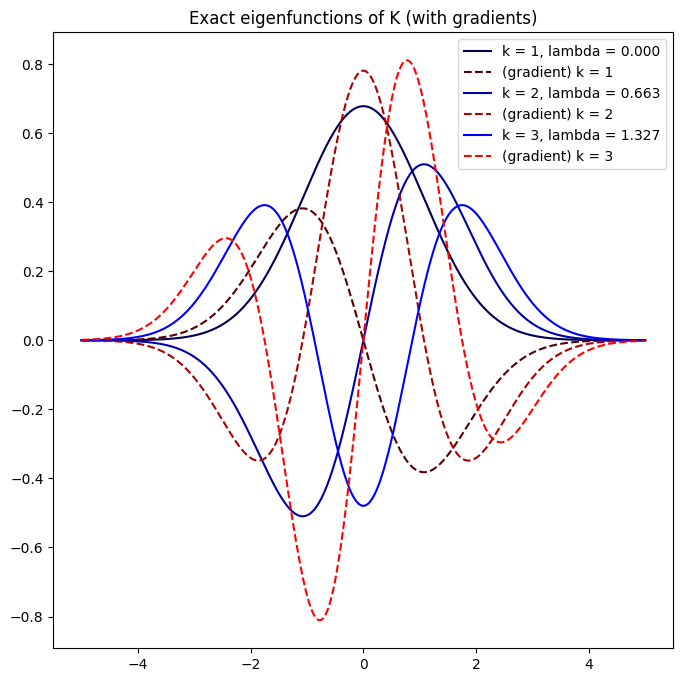

In [10]:
x = torch.linspace(-5, 5,1000)[:,None]

k = 3
fig, ax = plt.subplots(figsize=(8,8))
blue_colors = [(0, 0, (i / k)) for i in range(1, k + 1)]  # RGB: (Red, Green, Blue)
red_colors = [((i / k),0,0) for i in range(1, k + 1)]  # RGB: (Red, Green, Blue)


fx, grad_fx = exact_eigfunctions(x,k, params, return_grad=True)
eigvals = exact_eigvals(k, params)
for i in range(k):
    ax.plot(x, fx[:,i], color = blue_colors[i], label = f'k = {i+1}, lambda = {eigvals[i]:.3f}')
    ax.plot(x, grad_fx[:,i,0], color = red_colors[i], ls= '--', label = f'(gradient) k = {i+1}')

ax.set_title('Exact eigenfunctions of K (with gradients)')
plt.legend()

As a sanity check, we can estimate the inner products and verify that the eigenfunctions are indeed orthogonal wrt to the measure
$$<f,g>_{\mu} = \int f(x)g(x) \exp\left(\frac{1}{\lambda}x^T A x\right)dx.$$
In our case, we have a positive definite $A$, so estimation of the integral using expectations requires the following trick:
$$<f,g>_{\mu} = \int \left(f(x)g(x) \exp\left(\frac{2}{\lambda}x^T A x\right)\right) \exp\left(-\frac{1}{\lambda}x^T A x\right)dx = \frac{(2\pi)^{d/2}}{\det\left(\frac{2A}{\lambda}\right)^{1/2}}\mathbb{E}_x\left[f(x)g(x) \exp\left(\frac{2}{\lambda}x^T A x\right)\right]$$
where $x \sim \mathcal{N}\left(0, \left(\frac{2A}{\lambda}\right)^{-1}\right)$


In [11]:
k = 20
num_samples = int(1e5)
if torch.linalg.eigvalsh(A)[0] > 0:
    equilibrium_energy = QuadraticEnergy(A * 2 / lmbda)
    samples = equilibrium_energy.exact_sample((num_samples,))
    fsamples = exact_eigfunctions(samples, k, params)
    # compute inner products using trick
    quadratic_form = torch.exp(torch.einsum('ij, ij -> i',samples @ A * 2 / lmbda, samples))

    normalizer = ((2*math.pi)**(dim/2))/torch.linalg.det(2/lmbda * A) ** (1/2)

    inner_prods = (fsamples[:,None,:] * fsamples[:,:,None] * quadratic_form[:,None,None]).mean(dim=0) * normalizer

else:
    equilibrium_energy = QuadraticEnergy(-A * 2 / lmbda)
    samples = equilibrium_energy.exact_sample((num_samples,))
    normalizer = ((2*math.pi)**(dim/2))/torch.linalg.det(-2/lmbda * A) ** (1/2)

    fsamples = exact_eigfunctions(samples, k, params)

    inner_prods = (fsamples[:,None,:] * fsamples[:,:,None]).mean(dim=0) * normalizer

Text(0.5, 1.0, 'Inner products of eigenfunctions (MSE = 8.877e-04)')

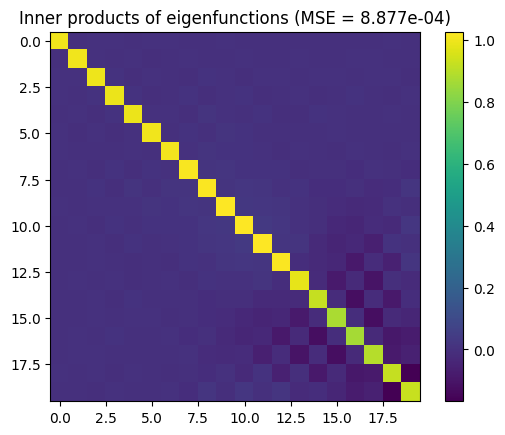

In [12]:
# sanity check: eigenfunctions are orthonormal
plt.imshow(inner_prods)
err = ((inner_prods - torch.eye(inner_prods.size(0))) ** 2).mean()
plt.colorbar()
plt.title(f'Inner products of eigenfunctions (MSE = {err:.3e})')

### Solving the PDE

We now wish to solve the PDE using the learned eigenfunctions. Essential for this is computing inner products of the form $<\exp(-\lambda^{-1}g), \phi_\alpha>_\mu$ for our terminal reward $g$ and eigenfunctions $\phi_\alpha$. In our case, we have $g = x^TQx$, and hence the inner product can be computed as
$$<\exp(-\lambda^{-1}g), \phi_\alpha>_{\mu} =  \frac{(2\pi)^{d/2}}{\det\left(\frac{2A}{\lambda}\right)^{1/2}}\mathbb{E}_{x \sim \mathcal{N}\left(0, \left(\frac{2A}{\lambda}\right)^{-1}\right)}\left[\phi_\alpha(x) \exp\left(x^T \left(\frac{2}{\lambda}A - \frac{1}{\lambda}Q\right) x\right)\right]$$




In [13]:
def compute_inner_prods(k, params, num_samples=10000, batch_size=10000):
    """
    Compute inner products between eigenfunctions and initial condition exp(-g/lambda)
    using GPU for intermediate computations, with inputs and outputs on CPU.
    
    Args:
        k (int): number of inner prods to compute
        params (dict): model parameters
        num_samples (int): number of samples to use for computing inner prod
        batch_size (int): maximum number of samples to process in a single batch
    Returns:
        inner_prods (tensor)[k]: inner products (on CPU)
    """
    assert num_samples % batch_size == 0

    lmbda = params['lmbda']

    params['A'] = params['A'].to("cuda")  # Move matrix A to GPU
    params['Q'] = params['Q'].to("cuda")  # Move matrix Q to GPU
    params['P'] = params['P'].to("cuda")  # Move matrix P to GPU
    A = params['A']
    Q = params['Q']

    dim = A.size(0)  # Dimension of the problem

    # Check the eigenvalues of A
    min_eigval = torch.linalg.eigvalsh(A).min().item()

    if min_eigval > 0:
        equilibrium_energy = QuadraticEnergy(params['A'] * 2 / lmbda)
        normalizer = ((2 * math.pi) ** (dim / 2)) / torch.linalg.det(2 / lmbda * A).sqrt()

        inner_prods = torch.zeros(k, device="cuda")  # Initialize on GPU
        total_batches = num_samples // batch_size

        for batch_idx in tqdm(range(total_batches)):
            # Sample batch
            samples = equilibrium_energy.exact_sample((batch_size,)).to("cuda")
            fsamples = exact_eigfunctions(samples, k, params).to("cuda")
            quadratic_form = torch.exp(
                torch.einsum("ij, ij -> i", samples @ (A * 2 / lmbda - Q / lmbda), samples)
            )
            inner_prods += (fsamples * quadratic_form[:, None]).mean(dim=0)

        inner_prods /= total_batches  # Normalize by the total number of samples
        inner_prods *= normalizer

    elif min_eigval < 0:
        equilibrium_energy = QuadraticEnergy(-params['A'] * 2 / lmbda)

        inner_prods = torch.zeros(k, device="cuda")  # Initialize on GPU
        total_batches = num_samples // batch_size

        for batch_idx in tqdm(range(total_batches)):
            # Sample batch
            samples = equilibrium_energy.exact_sample((batch_size,)).to("cuda")
            fsamples = exact_eigfunctions(samples, k, params).to("cuda")
            quadratic_form = torch.exp(
                torch.einsum("ij, ij -> i", samples @ (-Q / lmbda), samples)
            )
            inner_prods = inner_prods + (fsamples * quadratic_form[:, None]).mean(dim=0)

        inner_prods /= total_batches  # Normalize by the total number of samples

    # Move the result back to CPU
    params['A'] = params['A'].to("cpu")  # Move matrix A to CPU
    params['Q'] = params['Q'].to("cpu")  # Move matrix Q to CPU
    params['P'] = params['P'].to("cpu")  # Move matrix Q to CPU
    return inner_prods.to("cpu")


In [14]:
k = 20
inner_prods = compute_inner_prods(k, params, num_samples = 20_000_000, batch_size=1_000_000)
eigvals = exact_eigvals(k, params, shift = False)

100%|██████████| 20/20 [00:01<00:00, 11.34it/s]


Text(0.5, 1.0, 'Inner products and eigvals')

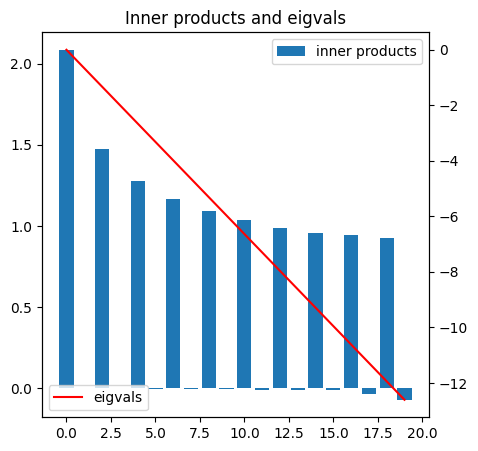

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(np.arange(len(inner_prods)),inner_prods, label = 'inner products')
ax2 = ax.twinx()
ax2.plot(-eigvals, color = 'red', label = 'eigvals')
ax.legend()
ax2.legend(loc = 'lower left')
plt.title('Inner products and eigvals')

Solving the PDE is now simply a matter of plugging in the formula 
$$v(x,t) = \sum_{k=0}^\infty <e^{-\lambda^{-1}g}, \phi_k>_\mu \phi_k e^{-\lambda_k t}$$

In [16]:
def compute_sol(x,t,k,params,num_samples = 10000,batch_size = 10000, return_grad = False):
    """
    Compute solution of the PDE at points x and time t.
    Args:
        x (tensor)[N,d]: points where to evaluate
        t (tensor)[N]: time points where to evaluate
        k (int): number of eigfunctions to use
        params (dict): problem parameters
        num_samples (int): number of samples to use for computing inner prod
        batch_size (int): maximum number of samples to process in a single batch    
        return_grad (bool): whether to return gradient of the solution   
    Returns:
        sol (tensor)[k,N]: solution using increasing number of eigfunctions
        (Optional) grad_sol (tensor)[k,N,d]: grad of solution
    """
    print('Computing inner prods... ', end = "")
    inner_prods = compute_inner_prods(k, params,num_samples=num_samples,batch_size=batch_size)

    if return_grad:
        print('Evaluating (grad of) eigenfunctions...', end = "")
        fx, grad_fx = exact_eigfunctions(x, k, params, return_grad = True)
        eigvals = exact_eigvals(k, params)
        print('Done!')

        # cumsum over first index of (k,n)
        sol = torch.cumsum(inner_prods[:,None] * 
                            torch.exp(-eigvals[:,None]*t[None,:]) * 
                            (fx.T),
                            0)
        # cumsum over first index of (k,n,d)
        grad_sol = torch.cumsum(inner_prods[:,None,None] * 
                            torch.exp(-eigvals[:,None,None]*t[None,:,None]) * 
                            (grad_fx.transpose(0,1)),
                            0)
        return sol, grad_sol
    
    else:
        print('Evaluating eigenfunctions... ', end = "")
        fx = exact_eigfunctions(x, k, params)
        eigvals = exact_eigvals(k, params)
        print('Done!')

        # sum over first index of (k,n)
        sol = torch.cumsum(inner_prods[:,None] * 
                            torch.exp(-eigvals[:,None]*t[None,:]) * 
                            (fx.T),
                            0)
        return sol

In [17]:
def compute_sol_err(x,t,k,params,num_samples = 10000,batch_size = 10000, return_grad = False, err = 1e-3):
    """
    Compute solution of the PDE at points x and time t, adding some error to the eigensystem
    Args:
        x (tensor)[N,d]: points where to evaluate
        t (tensor)[N]: time points where to evaluate
        k (int): number of eigfunctions to use
        params (dict): problem parameters
        num_samples (int): number of samples to use for computing inner prod
        batch_size (int): maximum number of samples to process in a single batch    
        return_grad (bool): whether to return gradient of the solution   
        err (float): magitude of error added
    Returns:
        sol (tensor)[k,N]: solution using increasing number of eigfunctions
        (Optional) grad_sol (tensor)[k,N,d]: grad of solution
    """
    print('Computing inner prods... ', end = "")
    inner_prods = compute_inner_prods(k, params,num_samples=num_samples,batch_size=batch_size)

    if return_grad:
        print('Evaluating (grad of) eigenfunctions...', end = "")
        fx, grad_fx = exact_eigfunctions(x, k, params, return_grad = True)

        eigvals = exact_eigvals(k, params)
        print('Done!')

        # add errors
        fx = fx*(1+err*torch.randn_like(fx))
        grad_fx = grad_fx*(1+err*torch.randn_like(grad_fx))
        eigvals = eigvals*(1+err*torch.randn_like(eigvals))
        inner_prods = inner_prods*(1+err*torch.randn_like(inner_prods))

        # cumsum over first index of (k,n)
        sol = torch.cumsum(inner_prods[:,None] * 
                            torch.exp(-eigvals[:,None]*t[None,:]) * 
                            (fx.T),
                            0)
        # cumsum over first index of (k,n,d)
        grad_sol = torch.cumsum(inner_prods[:,None,None] * 
                            torch.exp(-eigvals[:,None,None]*t[None,:,None]) * 
                            (grad_fx.transpose(0,1)),
                            0)
        return sol, grad_sol
    
    else:
        print('Evaluating eigenfunctions... ', end = "")
        fx = exact_eigfunctions(x, k, params)
        eigvals = exact_eigvals(k, params)
        print('Done!')

        # add errors
        fx = fx*(1+err*torch.randn_like(fx))
        eigvals = eigvals*(1+err*torch.randn_like(eigvals))
        inner_prods = inner_prods*(1+err*torch.randn_like(inner_prods))

        # sum over first index of (k,n)
        sol = torch.cumsum(inner_prods[:,None] * 
                            torch.exp(-eigvals[:,None]*t[None,:]) * 
                            (fx.T),
                            0)
        return sol

In [18]:
# sanity check that we can compute gradients
x = torch.linspace(-3,3,1000,requires_grad=True)[:,None]
t = torch.ones((1000,))*0.5
k = 20

sol, grad_sol = compute_sol(x,t,k,params,num_samples = 100000,batch_size = 100000, return_grad = True)

Computing inner prods... 

100%|██████████| 1/1 [00:00<00:00, 20.84it/s]

Evaluating (grad of) eigenfunctions...Done!


In [19]:
# verify gradient computation
grad_outputs = torch.eye(k)[:,None,:].expand([k,x.shape[0],k])
grad_fx = torch.autograd.grad(outputs = sol.T, inputs = x, grad_outputs = grad_outputs, is_grads_batched=True, create_graph=True)[0].transpose(0,1)
torch.allclose(grad_fx, grad_sol.transpose(0,1))

True

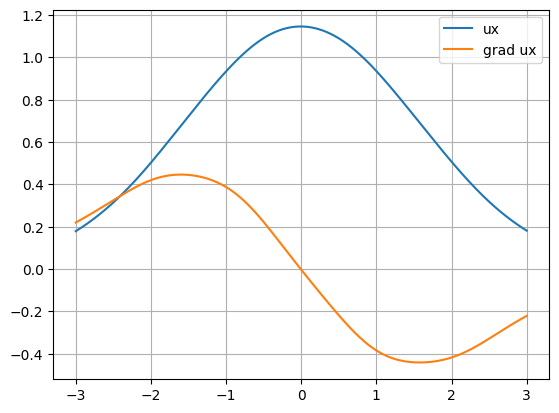

In [20]:
plt.plot(x.detach(),sol.T.detach()[:,-1], label = 'ux')
plt.plot(x.detach(),grad_sol.transpose(0,1).detach()[:,-1,0] , label = 'grad ux')

plt.grid()
plt.legend()

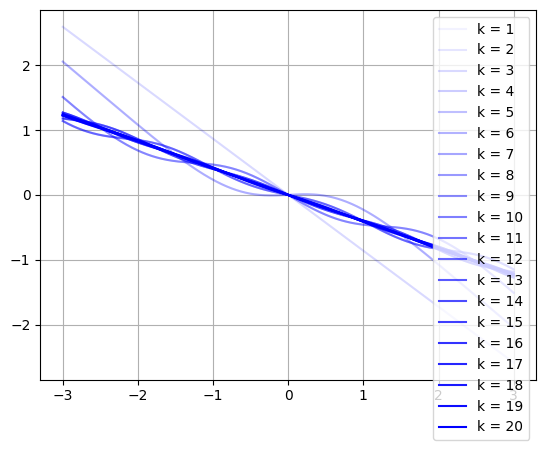

In [21]:
u = grad_sol.detach()[:,:,0] / sol.detach()
for i in range(k):
    plt.plot(x.detach(), u[i,:],label = f'k = {i+1}', color = 'blue', alpha = (i+1)/20)
plt.grid()
plt.legend()

As discussed earlier, we can retrieve the optimal control from the PDE as
$$u^*(x,t) = \sigma_0\lambda \frac{\nabla v(x,t)}{v(x,t)}$$

In [22]:
def compute_optimal_control_eigf(x,t,k,params,num_samples = 10000,batch_size=10000):
    """
    Compute optimal control at points x and times t using eigenfunctions
    Args:
        x (tensor)[N,d]: points where to evaluate
        t (tensor)[N]: time points where to evaluate
        k (int): number of eigfunctions to use
        num_samples (int): number of samples to use for computing inner prod
        batch_size (int): maximum number of samples to process in a single batch  
    Returns:
        u (tensor)[k,N,d]: computed control
    """
    torch.manual_seed(0)
    T = params['T']

    sol, grad_sol = compute_sol(x,T-t,k,params,num_samples = num_samples, batch_size=batch_size, return_grad=True)

    u = params['lmbda'] * grad_sol / sol[:,:,None]

    return u

def compute_optimal_control_eigf_err(x,t,k,params,num_samples = 10000,batch_size=10000, err = 1e-3):
    """
    Compute optimal control at points x and times t using eigenfunctions, adding some error to the true eigenfunctions
    Args:
        x (tensor)[N,d]: points where to evaluate
        t (tensor)[N]: time points where to evaluate
        k (int): number of eigfunctions to use
        num_samples (int): number of samples to use for computing inner prod
        batch_size (int): maximum number of samples to process in a single batch  
    Returns:
        u (tensor)[k,N,d]: computed control
    """
    torch.manual_seed(0)
    T = params['T']

    sol, grad_sol = compute_sol_err(x,T-t,k,params,num_samples = num_samples, batch_size=batch_size, return_grad=True, err=err)

    u = params['lmbda'] * grad_sol / sol[:,:,None]

    return u

In [87]:
dim = 20
# easy params
A = torch.eye(dim) * 0.2 
P = torch.eye(dim) * 0.2
Q = torch.eye(dim) * 0.1
# hard params
# A = torch.eye(dim)
# P = torch.eye(dim)
# Q = torch.eye(dim) * 0.5

sigma = torch.eye(dim)
lmbda = 1.0
T = 5

params = {'A': A, 'P': P, 'Q': Q, 'sigma': sigma, 'lmbda': lmbda, 'T': T}

K = 500
N = 64
k = 200
x = torch.randn((N,dim)) * 0.5
t = torch.linspace(0,T,K+1)

trajectory, optimal_control = optimal_control_trajectory(x, T, K, params, seed = 42)

100%|██████████| 500/500 [00:00<00:00, 1816.71it/s]


In [88]:
# trajectories flattened: first everything at t=0, then t= dt, etc
stacked_trajectories = trajectory.reshape((N*(K+1),dim))
assert stacked_trajectories[1,0] == trajectory[0,1,0]

# times for evaluation
t_eval = torch.repeat_interleave(t,N)

num_samples = 100_000
batch_size= 100000

# k, N(K+1), dim
eigf_control = compute_optimal_control_eigf(stacked_trajectories,
                                            t_eval,
                                            k,
                                            params,
                                            num_samples,
                                            batch_size)

reshaped_eigf_control = eigf_control.reshape(k,K+1,N,dim)
assert eigf_control[1,2,0] == reshaped_eigf_control[1,0,2,0]

Computing inner prods... 

100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Evaluating (grad of) eigenfunctions...Done!


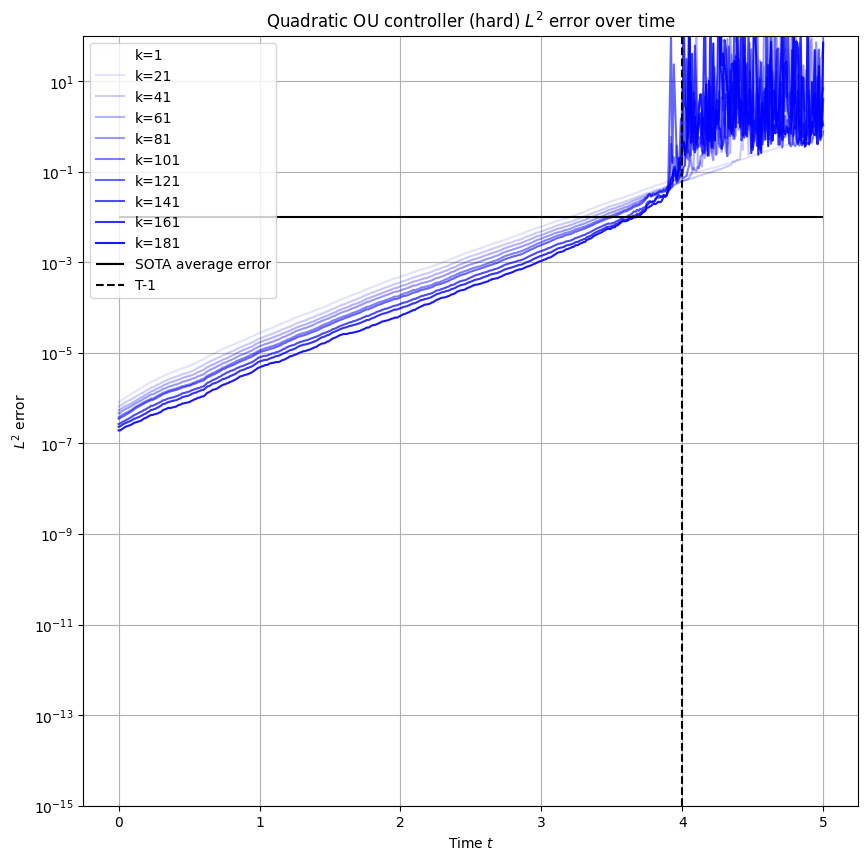

In [89]:
error = ((reshaped_eigf_control - optimal_control[None,:,:,:])**2).mean(dim=2).mean(dim=-1)
fig, ax = plt.subplots(figsize=(10,10))
for i in range(0,k,max(1,k//10)):
    ax.plot(t,error[i,:], color = 'blue', alpha = (i+1)/ k, label = f'k={i+1}')
ax.set_yscale('log')
ax.hlines(1e-2,t[0],t[-1],color='black', label='SOTA average error')
ax.vlines(T-1,1e-15,1e2, color = 'black', ls = '--', label = 'T-1')
ax.set_ylim(1e-15,1e2)
ax.set_xlabel('Time $t$')
ax.set_ylabel('$L^2$ error')
ax.set_title('Quadratic OU controller (hard) $L^2$ error over time')
ax.legend()
ax.grid()

In [78]:
# trajectories flattened: first everything at t=0, then t= dt, etc
stacked_trajectories = trajectory.reshape((N*(K+1),dim))
assert stacked_trajectories[1,0] == trajectory[0,1,0]

# times for evaluation
t_eval = torch.repeat_interleave(t,N)

num_samples = 100_000
batch_size= 100000

# k, N(K+1), dim
eigf_control = compute_optimal_control_eigf_err(stacked_trajectories,
                                            t_eval,
                                            k,
                                            params,
                                            num_samples,
                                            batch_size,
                                            err = 1e-3)

reshaped_eigf_control = eigf_control.reshape(k,K+1,N,dim)
#assert eigf_control[1,2,0] == reshaped_eigf_control[1,0,2,0]

Computing inner prods... 

100%|██████████| 1/1 [00:00<00:00, 128.68it/s]

Evaluating (grad of) eigenfunctions...Done!


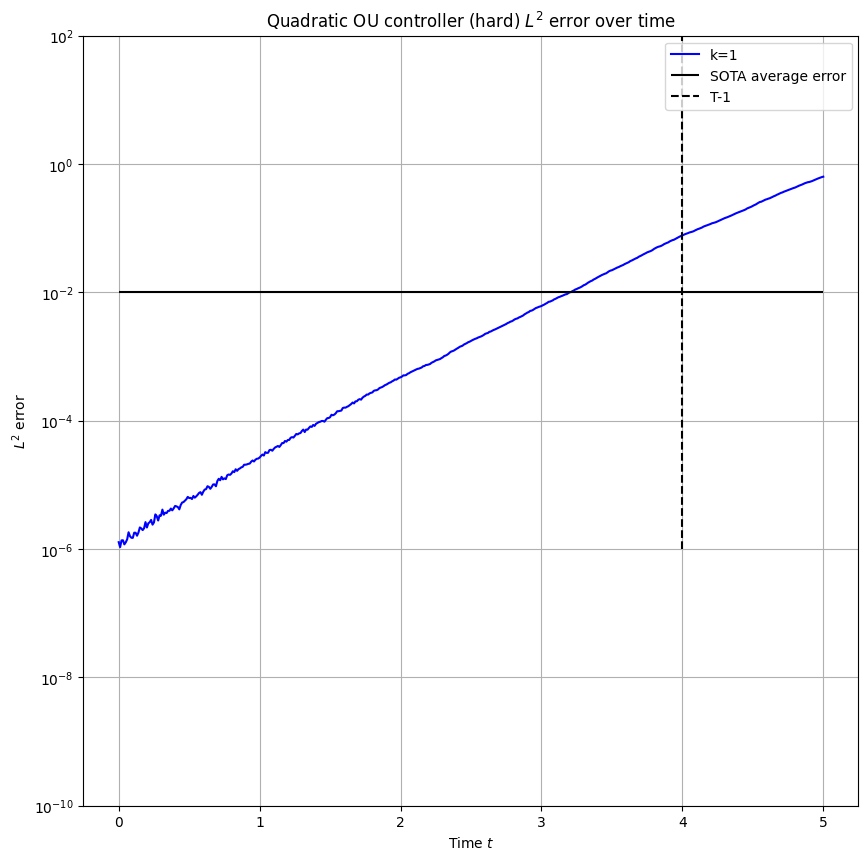

In [80]:
error = ((reshaped_eigf_control - optimal_control[None,:,:,:])**2).mean(dim=2).mean(dim=-1)
fig, ax = plt.subplots(figsize=(10,10))
for i in range(0,k,max(1,k//10)):
    ax.plot(t,error[i,:], color = 'blue', alpha = (i+1)/ k, label = f'k={i+1}')
ax.set_yscale('log')
ax.hlines(1e-2,t[0],t[-1],color='black', label='SOTA average error')
ax.vlines(T-1,1e-6,1e2, color = 'black', ls = '--', label = 'T-1')
ax.set_ylim(1e-10,1e2)
ax.set_xlabel('Time $t$')
ax.set_ylabel('$L^2$ error')
ax.set_title('Quadratic OU controller (hard) $L^2$ error over time')
ax.legend()
ax.grid()

### Learning eigenfunctions

Let us know see whether we can learn the eigenfunctions of this new operator.

We first recap the exact eigenfunctions

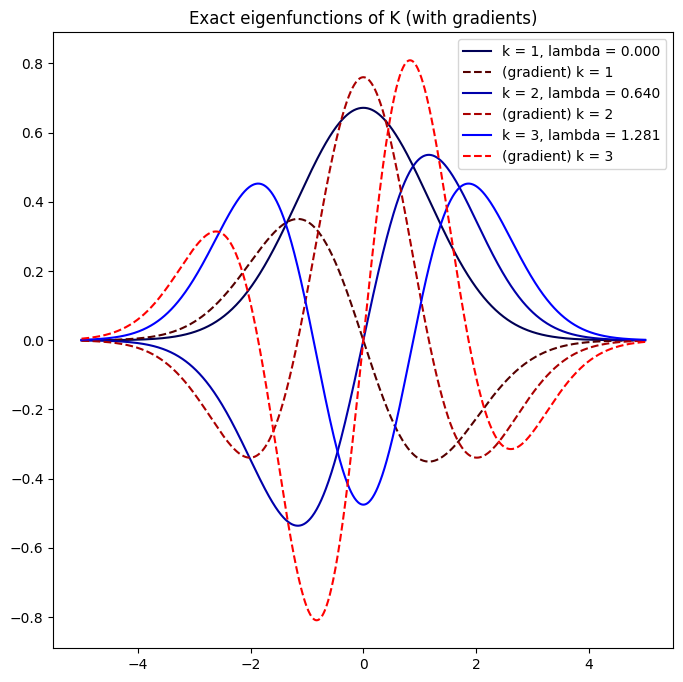

In [23]:
dim = 1
A = torch.eye(dim) * 0.1
P = torch.eye(dim) * 0.2
Q = torch.eye(dim) * 0.1
sigma = torch.eye(dim)
lmbda = 1

params = {'A': A, 'P': P, 'Q': Q, 'sigma': sigma, 'lmbda': lmbda}

D = compute_D(A, P, lmbda)

x = torch.linspace(-5, 5,1000)[:,None]

k = 3
fig, ax = plt.subplots(figsize=(8,8))
blue_colors = [(0, 0, (i / k)) for i in range(1, k + 1)]  # RGB: (Red, Green, Blue)
red_colors = [((i / k),0,0) for i in range(1, k + 1)]  # RGB: (Red, Green, Blue)


fx, grad_fx = exact_eigfunctions(x,k, params, return_grad=True)
eigvals = exact_eigvals(k, params)
for i in range(k):
    ax.plot(x, fx[:,i], color = blue_colors[i], label = f'k = {i+1}, lambda = {eigvals[i]:.3f}')
    ax.plot(x, grad_fx[:,i,0], color = red_colors[i], ls= '--', label = f'(gradient) k = {i+1}')

ax.set_title('Exact eigenfunctions of K (with gradients)')
plt.legend()

In [24]:
energy = QuadraticEnergy(-2 * A / lmbda)
samples = energy.exact_sample((100000,))

p = 200

kernel_params = {
    'dim': 1,
    'scale': 1.2,
}

kernel = GaussianKernel(kernel_params)
basis_points = energy.exact_sample((p,))
kernel_basis = KernelBasis(kernel, basis_points)
basis = ConstantBasis(kernel_basis)

def Rfunc(x):
    return torch.einsum("ij, ij -> i", x @ P, x) * 2 / lmbda**2

solver_params = {
    'verbose': True,
    'num_samples': 100000,
    'batch_size': 10000
}
k = 5

solver = GalerkinSolver(energy, samples, solver_params, Rfunc = Rfunc)
solver = solver.fit(basis, k = k, L_reg = 1e-6, phi_reg= 1e-12, seed = 42)

In [25]:
normalizer = ((2*math.pi)**(dim/2) / torch.linalg.det(-2/lmbda * A + 2 * D) ** (1/2))

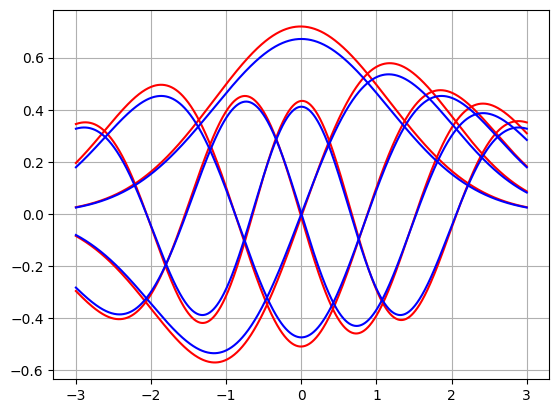

In [27]:
x = torch.linspace(-3,3,1000)[:,None]

fitted_eigfuncs = solver.predict(x) / normalizer
exact_eigfuncs = exact_eigfunctions(x, k, params) 

#fitted_eigfuncs = solver.predict(t)

# eigenfunctions are only determined up to sign
err = ((fitted_eigfuncs - exact_eigfuncs)**2).mean(dim=0)
neg_err = ((-fitted_eigfuncs - exact_eigfuncs)**2).mean(dim=0)

adjusted_fitted_eigfuncs = torch.where(err < neg_err, fitted_eigfuncs, -fitted_eigfuncs)

plt.plot(x,adjusted_fitted_eigfuncs, color = 'red')
plt.plot(x,exact_eigfuncs, color = 'blue')
plt.grid()

In [30]:
exact_eigvals(k, params)

tensor([0.0000, 0.6403, 1.2806, 1.9209, 2.5612])

In [32]:
(solver.eigvals - solver.eigvals.min()) / 2

tensor([0.0000, 0.6419, 1.2845, 1.9285, 2.5529])

In [33]:
def compute_optimal_control_eigf_fitted(x,t,solver,params,energy,num_samples = 10000):
    """
    Compute optimal control at points x and times t using fitted eigenfunctions
    Args:
        x (tensor)[N,d]: points where to evaluate
        t (tensor)[N]: time points where to evaluate
        solver (BaseSolver): fitted solver object
        params
        energy: energy for inner product
        num_samples (int): number of samples to use for computing inner prod
    Returns:
        u (tensor)[k,N,d]: computed control
    """
    torch.manual_seed(0)
    T = params['T']
    
    samples = energy.exact_sample((num_samples,))
    fsamples = solver.predict(samples)
    gsamples = -1/params['lmbda'] * torch.einsum("ij, ij -> i", samples @ params['Q'], samples)
    inner_prods = energy.inner_prod(samples, fsamples, gsamples[:,None]).squeeze(1)

    print('Evaluating (grad of) eigenfunctions...', end = "")
    fx = solver.predict(x)
    grad_fx = solver.predict_grad(x)
    eigvals = solver.eigvals
    eigvals = eigvals - eigvals.min()
    print(eigvals)
    print('Done!')

    t = T - t

    # cumsum over first index of (k,n)
    sol = torch.cumsum(inner_prods[:,None] * 
                        torch.exp(-eigvals[:,None]*t[None,:]) * 
                        (fx.T),
                        0)
    # cumsum over first index of (k,n,d)
    grad_sol = torch.cumsum(inner_prods[:,None,None] * 
                        torch.exp(-eigvals[:,None,None]*t[None,:,None]) * 
                        (grad_fx.transpose(0,1)),
                        0)

    u = params['lmbda'] * grad_sol / sol[:,:,None]

    return u

In [34]:
dim = 20
# easy params
A = torch.eye(dim) * 0.2 
P = torch.eye(dim) * 0.2
Q = torch.eye(dim) * 0.1
# hard params
A = torch.eye(dim)
P = torch.eye(dim)
Q = torch.eye(dim) * 0.5

sigma = torch.eye(dim)
lmbda = 1.0
T = 5

params = {'A': A, 'P': P, 'Q': Q, 'sigma': sigma, 'lmbda': lmbda, 'T': T}

K = 500
N = 64
k = 50
x = torch.randn((N,dim)) * 0.5
t = torch.linspace(0,T,K+1)

trajectory, optimal_control = optimal_control_trajectory(x, T, K, params, seed = 42)

100%|██████████| 500/500 [00:00<00:00, 2028.33it/s]


In [35]:
energy = QuadraticEnergy(-2 * A / lmbda)
samples = energy.exact_sample((100000,))

p = 100

kernel_params = {
    'dim': dim,
    'scale': 2.0,
}

kernel = GaussianKernel(kernel_params)
basis_points = energy.exact_sample((p,))
kernel_basis = KernelBasis(kernel, basis_points)
basis = ConstantBasis(kernel_basis)

def Rfunc(x):
    return torch.einsum("ij, ij -> i", x @ P, x) * 2 / lmbda**2

solver_params = {
    'verbose': True,
    'num_samples': 100000,
    'batch_size': 100000
}

solver = GalerkinSolver(energy, samples, solver_params, Rfunc = Rfunc)
solver = solver.fit(basis, k = k, L_reg = 1e-6, phi_reg= 1e-10, seed = 42)

In [36]:
solver.eigvals

tensor([ 50.7590,  51.6878,  51.7895,  52.0353,  52.2254,  52.4260,  52.6078,
         52.7459,  52.9354,  53.1610,  53.2468,  53.4370,  53.6173,  53.6680,
         53.8410,  53.9016,  54.0413,  54.3229,  54.4821,  54.5249,  54.6936,
         55.3118,  55.9592,  56.1092,  56.2683,  56.5326,  56.9208,  57.7820,
         58.1509,  58.6813,  58.9438,  59.0760,  59.6740,  60.4654,  62.8483,
         66.1904,  68.2184,  69.1485,  70.3790,  71.5947,  73.2102,  75.8263,
         76.8027,  80.8507,  83.9343,  88.8730,  92.3916,  99.3360, 110.1053,
        111.6258])

In [70]:
# trajectories flattened: first everything at t=0, then t= dt, etc
stacked_trajectories = trajectory.reshape((N*(K+1),dim))
assert stacked_trajectories[1,0] == trajectory[0,1,0]

# times for evaluation
t_eval = torch.repeat_interleave(t,N)

num_samples = 100_000

# k, N(K+1), dim
eigf_control = compute_optimal_control_eigf_fitted(stacked_trajectories,
                                            t_eval,
                                            solver,
                                            params,
                                            energy,
                                            num_samples)

reshaped_eigf_control = eigf_control.reshape(k,K+1,N,dim)
assert eigf_control[1,2,0] == reshaped_eigf_control[1,0,2,0]

Evaluating (grad of) eigenfunctions...Done!


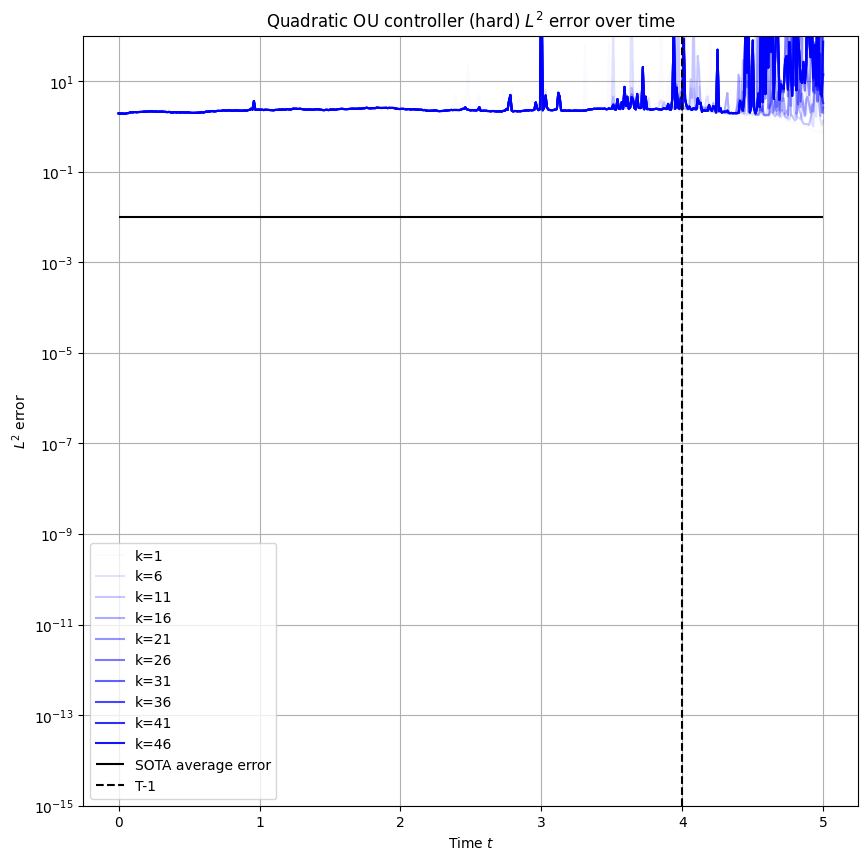

In [71]:
error = ((reshaped_eigf_control - optimal_control[None,:,:,:])**2).mean(dim=2).mean(dim=-1)
fig, ax = plt.subplots(figsize=(10,10))
for i in range(0,k,k//10):
    ax.plot(t,error[i,:], color = 'blue', alpha = (i+1)/ k, label = f'k={i+1}')
ax.set_yscale('log')
ax.hlines(1e-2,t[0],t[-1],color='black', label='SOTA average error')
ax.vlines(T-1,1e-15,1e2, color = 'black', ls = '--', label = 'T-1')
ax.set_ylim(1e-15,1e2)
ax.set_xlabel('Time $t$')
ax.set_ylabel('$L^2$ error')
ax.set_title('Quadratic OU controller (hard) $L^2$ error over time')
ax.legend()
ax.grid()